In [1]:
#%matplotlib inline
import os
import numpy as np
from PIL import Image
import matplotlib as mp
from matplotlib import pyplot,pylab
plt = pyplot
import scipy
from __future__ import division

import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
import string
import pandas as pd
from scipy import stats

%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs

import json
import pymongo as pm

from svgpathtools import parse_path

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

/Users/judithfan/Library/Python/2.7/lib/python/site-packages/scipy/special/__init__.py:640: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ufuncs import *
/Users/judithfan/Library/Python/2.7/lib/python/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/Users/judithfan/Library/Python/2.7/lib/python/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/Users/judithfan/Library/Python/2.7/lib/python/site-packages/scipy/special/_ellip_harm.py:7: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._ellip_harm_2 import _ellipsoid, _ellipsoid_norm
/Users/judithfan/Library/Python/2.7/lib/python/site-packages/scipy/interpolate/_bspline

## purpose

* upload sketches to S3 [maybe do this later]
* build stimulus dictionary and write to database

## upload sketches to S3 [todo later]

## build stimulus dictionary

In [2]:
## read in experimental metadata file (CSV)
path_to_metadata = 'sketchpad_basic_allcats.csv'
_meta = pd.read_csv(path_to_metadata)   ### raw meta with all categories

## subset by chairs
meta_chairs = _meta[_meta['category']=='chair'] ### subsetted meta with just chairs

## TODO: what we actually want Make sure that the data we're excluding from annotation 
## really the come from the trials where we had the shift-key artifact. 
## Right now, we are excluding sketches with numStrokes > mu + 3*sd, which is an imperfect proxy for that.
mu = np.mean(meta_chairs['numStrokes'])
sd = np.std(meta_chairs['numStrokes'])
thresh = mu + 3*sd
meta_chairs = meta_chairs[meta_chairs['numStrokes']<thresh]
meta_chairs.reset_index(inplace=True) ## reset index on meta_chairs

## sub-select good 4 chairs
## inlay>waiting>straight>leather
chairs4_list = ['inlay','waiting','straight','leather']
meta_chairs4 = meta_chairs[meta_chairs['target'].isin(chairs4_list)]
meta_chairs4.reset_index(inplace=True)

## assign which meta we will actually upload to mongo in this session
category_flag = 'chairs4' ## options: ['allcats','chairs','chairs4']

if category_flag == 'chairs':
    meta = meta_chairs
elif category_flag == 'chairs4':
    meta = meta_chairs4
elif category_flag == 'allcats':
    meta = _meta

In [3]:
## add parts list
parts =[]
for i in range(meta.shape[0]-1):
    if meta.category[i]=="chair":
        parts.append(["backrest,armrest,seat,leg"])        
    if meta.category[i]=="dog":
        parts.append(["eye,mouth,ear,head,neck,body,leg,tail"])
    if meta.category[i] == "bird":
        parts.append(["beak,head,body,wings,feet,tail"])
    if meta.category[i] == "car":
        parts.append(["bumper,lights,windshield,body,window,door,wheel"])
meta = meta.assign(parts=pd.Series(parts))

In [4]:
## add iteration name information
_iterationName = 'sketchpad_basic_{}'.format(category_flag)
iterationName = [_iterationName]*len(meta)
meta = meta.assign(iterationName=pd.Series(iterationName))

In [5]:
## svg string formatting
svg = []
for i,d in meta.iterrows():    
    splitted = d['svg'].split("'") ## parse string to re-split up into strokes
    svgString = [i for i in splitted if i[0]=='M'] ## check to make sure it is a real start of a spline
    svg.append(svgString)
meta = meta.assign(svg=pd.Series(svg)) 

In [6]:
## add numSplines to the meta data
numSplines = []
for sketch in sketch_svgs:
    num_splines = 0
    for stroke_ind,stroke in enumerate(sketch):
        parsed = parse_path(stroke)
        num_splines += len(parsed)
    numSplines.append(num_splines)
meta = meta.assign(numSplines=pd.Series(numSplines))     

NameError: name 'sketch_svgs' is not defined

In [ ]:
## add empty games list
games = [[] for i in np.arange(len(meta))]
meta = meta.assign(games=pd.Series(games))

In [ ]:
## how many games worth of data do we have?
print '{} unique games worth of data.'.format(len(np.unique(meta.gameID.values)))
print '{} unique sketches.'.format(len(meta))

## write out metadata to json file

## for example:
stimdict = meta.to_dict(orient='records')
stimdict
import json
with open('annotation_meta.js', 'w') as fout:
     json.dump(stimdict, fout)

### interlude to examine detailed statistics on constituent splines

In [7]:
## svg is a list of sketches
## each entry contains a list of strokes
## first let's convert into absolute coordinates
## then let's convert these into a list of splines that are "long enough"

In [8]:
def convert_relative_spline_to_absolute(parsed):
    svg_abs = ''
    for i,p in enumerate(parsed):
        if len(p)==4: ## cubic bezier
            svg_abs += ' M '
            svg_abs += '{},{}'.format(str(p.start.real),str(p.start.imag))
            svg_abs += ' C'
            svg_abs += ' {},{}'.format(str(p.control1.real),str(p.control1.imag))
            svg_abs += ' {},{}'.format(str(p.control2.real),str(p.control2.imag))
            svg_abs += ' {},{}'.format(str(p.end.real),str(p.end.imag)) 
        if len(p)==2: ## line segment
            svg_abs += ' M '
            svg_abs += '{},{}'.format(str(p.start.real),str(p.start.imag))
            svg_abs += ' L'
            svg_abs += ' {},{}'.format(str(p.end.real),str(p.end.imag))          
#     assert np.all(np.round(parsed)==np.round(parse_path(svg_abs)))==True
    return svg_abs

In [9]:
## get list of sketch svg converted to absolute coordinates
## grouped into **strokes**
svg_abs_strokes = []
for this_sketch in svg:
    sketch_abs = []
    for this_stroke in this_sketch:  
        this_stroke = this_stroke.replace('v0','') ## eliminate single points
        this_stroke = this_stroke.replace('h0','') ## eliminate single points
        parsed = parse_path(this_stroke)
        parsed_abs = convert_relative_spline_to_absolute(parsed)
        sketch_abs.append(parsed_abs)
    svg_abs_strokes.append(sketch_abs)

In [10]:
## get list of sketch svg converted to absolute coordinates
## grouped into **splines**
svg_abs_splines = [] 
stroke_num_within_sketch = [] ## get stroke num within sketch
for this_sketch in svg_abs_strokes:
    sketch_abs = []
    _stroke_num_within_sketch = []    
    for stroke_id,this_stroke in enumerate(this_sketch):
        this_path = parse_path(this_stroke)
        for i,p in enumerate(this_path):
            _svg_abs = ''
            if len(p)==4: ## cubic bezier
                _svg_abs += ' M '
                _svg_abs += '{},{}'.format(str(p.start.real),str(p.start.imag))
                _svg_abs += ' C'
                _svg_abs += ' {},{}'.format(str(p.control1.real),str(p.control1.imag))
                _svg_abs += ' {},{}'.format(str(p.control2.real),str(p.control2.imag))
                _svg_abs += ' {},{}'.format(str(p.end.real),str(p.end.imag)) 
            if len(p)==2: ## line segment
                _svg_abs += ' M '
                _svg_abs += '{},{}'.format(str(p.start.real),str(p.start.imag))
                _svg_abs += ' L'
                _svg_abs += ' {},{}'.format(str(p.end.real),str(p.end.imag))  
            sketch_abs.append(_svg_abs)
            _stroke_num_within_sketch.append(stroke_id)
    svg_abs_splines.append(sketch_abs)
    stroke_num_within_sketch.append(_stroke_num_within_sketch)

In [11]:
## create list of spline arc lengths nested in the same way as svg_abs_splines
svg_abs_spline_lengths = []
for sketch_ind,this_sketch in enumerate(svg_abs_splines):
    sketch_abs_length = []
    for spline_ind,spline in enumerate(this_sketch):
        curr_stroke_ind = stroke_num_within_sketch[sketch_ind][spline_ind]    
        curr_spline_length = parse_path(spline).length()
        sketch_abs_length.append(curr_spline_length)
    svg_abs_spline_lengths.append(sketch_abs_length)

In [12]:
def flatten(x):
    return [item for sublist in x for item in sublist]

(0, 200)

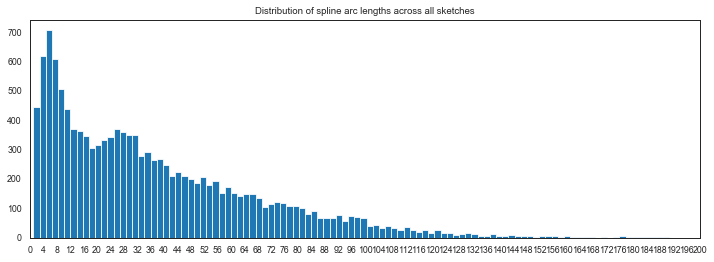

In [13]:
## get all spline lengths
flat_spline_lengths = flatten(svg_abs_spline_lengths)

## make figure
plt.figure(figsize=(12,4))
sns.set_context('paper')
plt.title('Distribution of spline arc lengths across all sketches')
plt.hist(flat_spline_lengths,200)
plt.xticks(np.linspace(0,200,51))
plt.xlim(0,200)

### upload stim dictionary to mongo (db = 'stimuli', collection='sketchpad_basic_recog')

In [ ]:
## do you want to upload a "development mode" collection for testing?
dev_mode = True 

In [ ]:
## load in the JSON that contains the svgData, object labels, and part labels
J = json.loads(open('annotation_meta.js',mode='ru').read())
assert len(J)==len(meta)

In [ ]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')

In [ ]:
## define the dbname and collection name
db = conn['stimuli']
if dev_mode:
    coll = db['svg_annotation_sketchpad_basic_{}_dev'.format(category_flag)]
else:
    coll = db['svg_annotation_sketchpad_basic_{}'.format(category_flag)]

In [ ]:
## actually add data now to the database (iff reallyRun==True)
reallyRun = True
if reallyRun:
    for (i,j) in enumerate(J):
        if i%250==0:
            print ('%d of %d' % (i,len(J)))
        coll.insert_one(j)
reallyRun = False        

In [ ]:
## How many sketches do we have in the database?
print 'We have {} sketches.'.format(coll.count())

## What kind of sketches do we have in the database?
print 'We have these kinds: {}'.format(str(coll.distinct('category')))